# DHS Data Preprocessing

- Harmonized data is here:
- https://docs.google.com/document/d/1So35M9Y9hSjligvYfas1Owb8ZjmbRjhRrjWIk9vp9yI/edit?tab=t.0

In [26]:
import geopandas as gpd
import os
import matplotlib.patches as mpatches
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
country = 'KHM'
os.chdir('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch')
data_folder = 'data/'

In [30]:
file_path = os.path.join(data_folder, 'KHM/DHS/sdr_national_data_2024-10-16/shps/sdr_national_data_dhs_2014.shp')

### MPI

In [31]:
years = ['00', '05', '10', '14', '21-22']
year = years[0]

In [32]:
#Path were all mpi shapes are
mpi_folders = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1UFnD8ofHi_4YXqnGCH4FLW8bapLdp4qX/DISES SIG/Dataset Information/MPI/'

In [33]:
#Load all gdfs into a dictionary

mpi = {}

for year in years: 

    #Generate paths and load files
    #Paths
    mpi_folder_file = f'mpi_khm_dhs{year}_hmn_clust_CI_mis/mpi_khm_dhs{year}_hmn_clust_CI_mis.shp'
    file_path = os.path.join(mpi_folders, mpi_folder_file)
    #Load
    mpi[year] = gpd.read_file(file_path)

In [34]:
pcrs = mpi['00'].crs

In [35]:
mpi_stats = {}

from statsmodels.stats.weightstats import DescrStatsW


for year in years: 
    # Create a weighted descriptive statistics object
    year_stats = {} 
    
    df = mpi[year]
    weighted_stats = DescrStatsW(df['mpi_0'], weights=df['tot_ppl'])
    year_stats['mean'] = weighted_stats.mean
    year_stats['std'] = weighted_stats.std
    year_stats['var'] = weighted_stats.var

    
    mpi_stats[year] = year_stats
    


In [36]:
df = pd.DataFrame(mpi_stats)

In [37]:
def plot_mean_std(df):
    # Extract the relevant columns
    time = df.columns  # Assuming the columns represent time intervals
    mean = df.loc['mean']
    std = df.loc['std']

    # Plot the mean
    plt.plot(time, mean, label='Mean', color='blue')

    # Fill between mean ± std
    plt.fill_between(time, mean - std, mean + std, color='blue', alpha=0.2, label='Mean ± 1 STD')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('MPI')
    plt.title('Mean and Std Cambodia (MPI_0')
    plt.legend()
    
    # Display the plot
    plt.show()

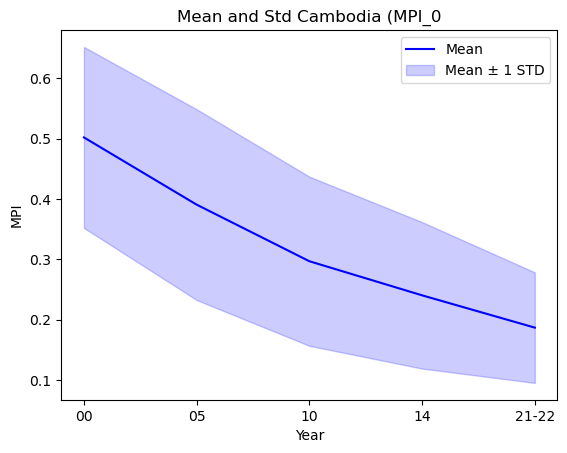

In [38]:
plot_mean_std(df)

# Treatment and the rest

In [39]:
# Load the shape file with geographic covariates
initial_shape_path = os.path.join(data_folder, country, 'panel/panel-khm-02082024-v2.shp')
gdf = gpd.read_file(initial_shape_path)
gdf = gdf.to_crs(pcrs)

In [40]:
gdf = gdf[['grid_id', 'cf_buffer5', 'geometry']]

In [41]:
for year in years:
    mpi[year] = mpi[year].sjoin(gdf)

In [42]:
mpi_stats = {}

for year in years: 
    # Create a dictionary to store stats for the year
    year_stats = {}
    
    df = mpi[year]
    
    # Filter for the 'cf_buffer5' subgroup
    df_t = df[df['cf_buffer5'] == 1]
    
    # Filter for the rest of the data (excluding 'cf_buffer5')
    df_rest = df[df['cf_buffer5'] == 0]
    
    # Weighted statistics for the 'cf_buffer5' subgroup
    if not df_t.empty:
        weighted_stats_t = DescrStatsW(df_t['mpi_0'], weights=df_t['tot_ppl'])
        year_stats['treatment'] = {
            'mean': weighted_stats_t.mean,
            'std': weighted_stats_t.std,
            'var': weighted_stats_t.var
        }
    
    # Weighted statistics for the rest of the data
    if not df_rest.empty:
        weighted_stats_rest = DescrStatsW(df_rest['mpi_0'], weights=df_rest['tot_ppl'])
        year_stats['rest'] = {
            'mean': weighted_stats_rest.mean,
            'std': weighted_stats_rest.std,
            'var': weighted_stats_rest.var
        }

    # Store the stats for the current year
    mpi_stats[year] = year_stats


In [43]:
#Get two df from the data
# Create two dictionaries to store mean and std for treatment and rest
treatment_data = {'mean': [], 'std': [], 'var': []}
rest_data = {'mean': [], 'std': [], 'var': []}
years_list = []  # To keep track of the years

# Populate the dictionaries from mpi_stats_dict
for year, stats in mpi_stats.items():
    years_list.append(year)  # Store the year
    
    # Extract stats for treatment
    if 'treatment' in stats:
        treatment_data['mean'].append(stats['treatment']['mean'])
        treatment_data['std'].append(stats['treatment']['std'])
        treatment_data['var'].append(stats['treatment']['var'])
    else:
        # If treatment data is missing, append None or NaN
        treatment_data['mean'].append(None)
        treatment_data['std'].append(None)
        treatment_data['var'].append(None)

    # Extract stats for the rest
    if 'rest' in stats:
        rest_data['mean'].append(stats['rest']['mean'])
        rest_data['std'].append(stats['rest']['std'])
        rest_data['var'].append(stats['rest']['var'])
    else:
        # If rest data is missing, append None or NaN
        rest_data['mean'].append(None)
        rest_data['std'].append(None)
        rest_data['var'].append(None)

# Convert the dictionaries to DataFrames, with years as columns
df1 = pd.DataFrame(treatment_data, columns=['mean', 'std', 'var'], index=years_list).T
df2 = pd.DataFrame(rest_data, columns=['mean', 'std', 'var'], index=years_list).T

In [44]:

def plot_mean_std(df1, df2, label1='Group 1', label2='Group 2', title='Mean and Std Comparison'):
    # Extract time from the DataFrame columns
    time = df1.columns  # Assuming the columns represent time intervals

    # Extract mean and std for df1 group
    mean_df1 = df1.loc['mean']
    std_df1 = df1.loc['std']

    # Extract mean and std for df2 group
    mean_df2 = df2.loc['mean']
    std_df2 = df2.loc['std']

    # Plot the mean and std for df1
    plt.plot(time, mean_df1, label=f'{label1} Mean', color='blue')
    plt.fill_between(time, mean_df1 - std_df1, mean_df1 + std_df1, 
                     color='blue', alpha=0.2, label=f'{label1} Mean ± 1 STD')

    # Plot the mean and std for df2
    plt.plot(time, mean_df2, label=f'{label2} Mean', color='green')
    plt.fill_between(time, mean_df2 - std_df2, mean_df2 + std_df2, 
                     color='green', alpha=0.2, label=f'{label2} Mean ± 1 STD')

    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('MPI')
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_mean_std(df1, df2, label1='cf_buffer5', label2='Rest', title='Mean and Std of MPI: cf_buffer5 vs Rest')


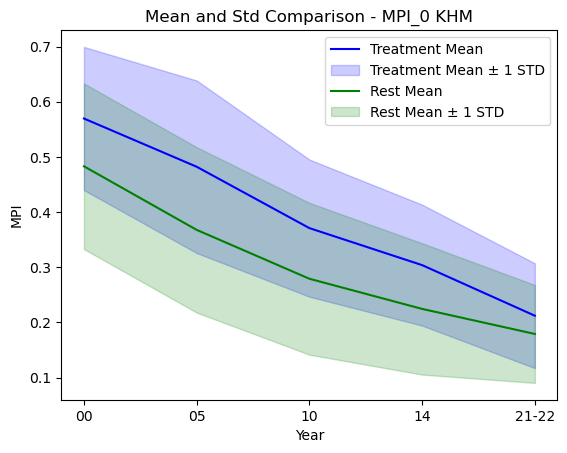

In [45]:
plot_mean_std(df1, df2, label1='Treatment', label2='Rest', title='Mean and Std Comparison - MPI_0 KHM')

### Treatment and control

In [ ]:
#Load treatment and control from Roberto
tc = gpd.read_file('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1Y83sGckPnURtqsg-y0FRgK1eOjNe7TSz/DISES shared/Data/Postmatching/treat_controls/CountryPSM_relevant.shp')

#Change crs to pcrs
tc = tc.to_crs(pcrs)

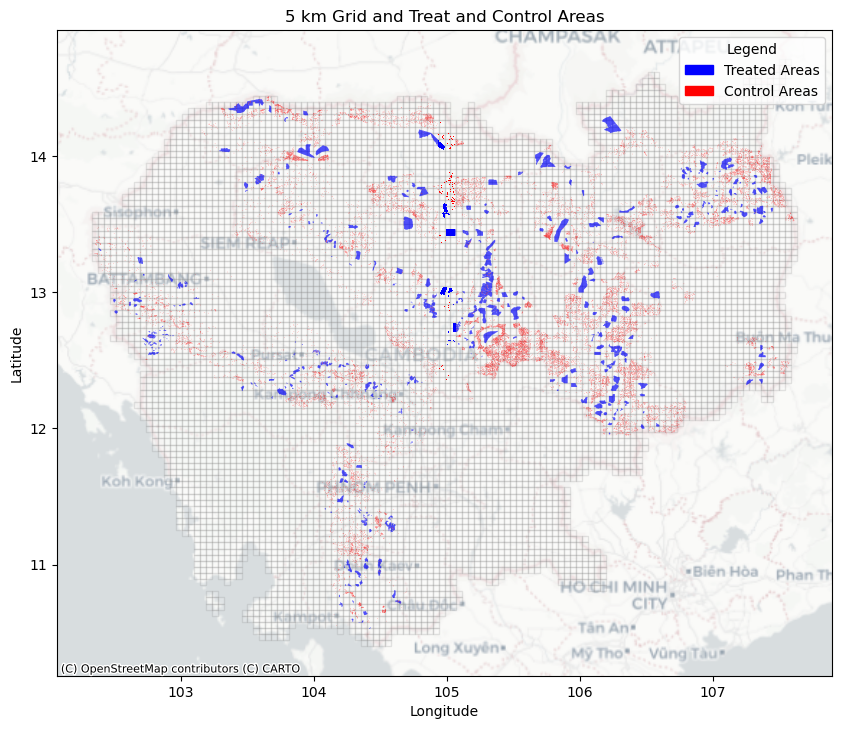

In [48]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
gdf.plot(ax=ax, facecolor='white', edgecolor='grey', alpha=0.2)

# Plot treat areas
tc[tc['treat'] == 1].plot(ax=ax, color='blue', label='Treated Areas')

# Plot control areas
tc[tc['treat'] == 0].plot(ax=ax, color='red', label='Control Areas')

# Add a black-and-white basemap (Stamen Toner Lite)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.9, crs=pcrs)

# Add a legend
treated_patch = mpatches.Patch(color='blue', label='Treated Areas')
control_patch = mpatches.Patch(color='red', label='Control Areas')
ax.legend(handles=[treated_patch, control_patch], loc='upper right', title='Legend')

# Customize the plot (optional)
ax.set_title('5 km Grid and Treat and Control Areas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Save the plot
# plt.savefig(os.path.join(report_folder, '1. Grids - DHS Clusters.pdf'))
plt.show()


In [49]:
# Add a treatment column initialized to 3 (neither control nor treatment)
gdf['Treatment'] = 3

# Perform a spatial join to find intersections with treatment areas
gdf_with_treat = gpd.sjoin(gdf, tc[tc['treat'] == 1], how='left', predicate='intersects')

# Update Treatment to 1 for grids intersecting treatment areas
gdf.loc[gdf_with_treat.index[gdf_with_treat['treat'].notnull()], 'Treatment'] = 1

# Perform a spatial join to find intersections with control areas
gdf_with_control = gpd.sjoin(gdf[gdf['Treatment'] != 1], tc[tc['treat'] == 0], how='left', predicate='intersects')

# Update Treatment to 0 for grids intersecting control areas but not treatment areas
gdf.loc[gdf_with_control.index[gdf_with_control['treat'].notnull()], 'Treatment'] = 0


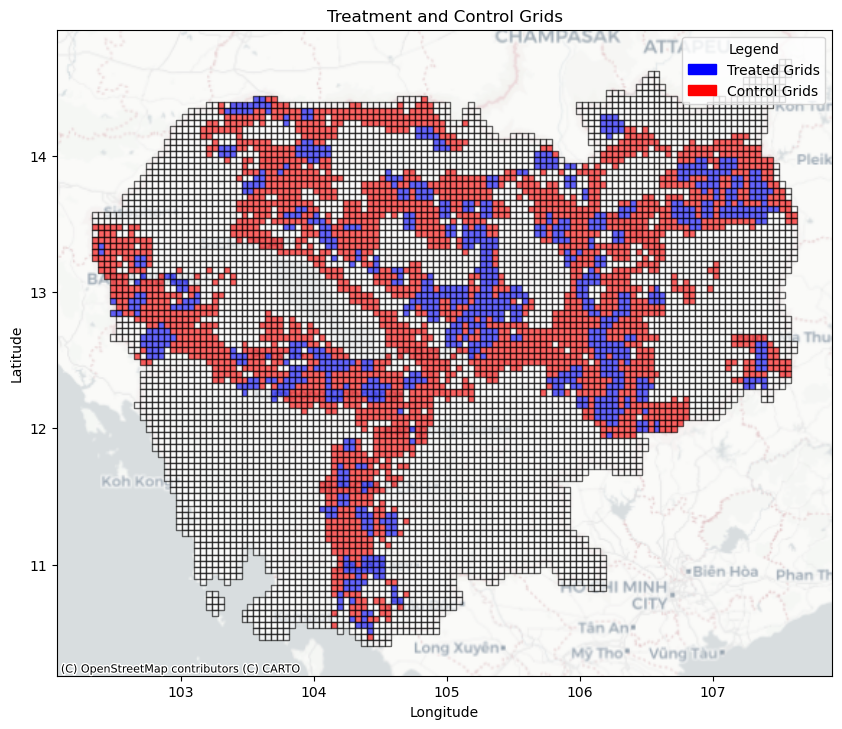

In [50]:
# Create a color mapping based on the Treatment values
color_map = {
    1: 'blue',    # Treatment areas
    0: 'red',     # Control areas
    3: 'white'     # Neither control nor treatment
}

# Map the Treatment values to colors
gdf['color'] = gdf['Treatment'].map(color_map)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid, using the color column
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', alpha=0.6)

# Add a black-and-white basemap (Stamen Toner Lite)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.9, crs=pcrs)

# Add title and axis labels
ax.set_title('Treatment and Control Grids')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a legend manually
import matplotlib.patches as mpatches
treated_patch = mpatches.Patch(color='blue', label='Treated Grids')
control_patch = mpatches.Patch(color='red', label='Control Grids')
#neutral_patch = mpatches.Patch(color='gray', label='Neutral Grids')
ax.legend(handles=[treated_patch, control_patch], loc='upper right', title='Legend')

# Show the plot
plt.show()

### Comparison

In [51]:
#Load all predictions gdfs into a dictionary

years = ['00', '05', '10', '14', '21']

mpi_p = {}

for year in years: 

    #Generate paths and load files
    #Paths
   
    mpi_folder_file = f'/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch/predictions/KHM-20{year}-mpi_0/KHM-20{year}-mpi_0.shp'
    file_path = os.path.join(mpi_folders, mpi_folder_file)
    #Load
    mpi_p[year] = gpd.read_file(file_path).to_crs(pcrs)

In [52]:
for year in years:
    mpi_p[year] = mpi_p[year].merge(gdf[['grid_id','Treatment', 'color']], on='grid_id', how='left')

In [53]:
# Load the shape file with geographic covariates
initial_shape_path = os.path.join(data_folder, country, 'panel/panel-khm-02082024-v2.shp')
gdf_total = gpd.read_file(initial_shape_path).to_crs(pcrs)

In [54]:
mpi_stats = {}

for year in years: 
    # Create a dictionary to store stats for the year
    year_stats = {}
    
    df = mpi_p[year]
    
    # Filter for the 'cf_buffer5' subgroup
    df_t = df[df['Treatment'] == 1]
    
    # Filter for the rest of the data (excluding 'cf_buffer5')
    df_c = df[df['Treatment'] == 0]
    
    year_stats['treatment'] = {
            'mean': df_t['mpi_0'].mean(),
            'std': df_t['mpi_0'].std(),
            'var': df_t['mpi_0'].var()
        }
    
    # Weighted statistics for the rest of the data
    year_stats['rest'] = {
            'mean': df_c['mpi_0'].mean(),
            'std': df_c['mpi_0'].std(),
            'var': df_c['mpi_0'].var()
        }

    # Store the stats for the current year
    mpi_stats[year] = year_stats


In [55]:
#Get two df from the data
# Create two dictionaries to store mean and std for treatment and rest
treatment_data = {'mean': [], 'std': [], 'var': []}
rest_data = {'mean': [], 'std': [], 'var': []}
years_list = []  # To keep track of the years

# Populate the dictionaries from mpi_stats_dict
for year, stats in mpi_stats.items():
    years_list.append(year)  # Store the year
    
    # Extract stats for treatment
    if 'treatment' in stats:
        treatment_data['mean'].append(stats['treatment']['mean'])
        treatment_data['std'].append(stats['treatment']['std'])
        treatment_data['var'].append(stats['treatment']['var'])
    else:
        # If treatment data is missing, append None or NaN
        treatment_data['mean'].append(None)
        treatment_data['std'].append(None)
        treatment_data['var'].append(None)

    # Extract stats for the rest
    if 'rest' in stats:
        rest_data['mean'].append(stats['rest']['mean'])
        rest_data['std'].append(stats['rest']['std'])
        rest_data['var'].append(stats['rest']['var'])
    else:
        # If rest data is missing, append None or NaN
        rest_data['mean'].append(None)
        rest_data['std'].append(None)
        rest_data['var'].append(None)

# Convert the dictionaries to DataFrames, with years as columns
df1 = pd.DataFrame(treatment_data, columns=['mean', 'std', 'var'], index=years_list).T
df2 = pd.DataFrame(rest_data, columns=['mean', 'std', 'var'], index=years_list).T

In [56]:

def plot_mean_std(df1, df2, label1='Group 1', label2='Group 2', title='Mean and Std Comparison'):
    # Extract time from the DataFrame columns
    time = df1.columns  # Assuming the columns represent time intervals

    # Extract mean and std for df1 group
    mean_df1 = df1.loc['mean']
    std_df1 = df1.loc['std']

    # Extract mean and std for df2 group
    mean_df2 = df2.loc['mean']
    std_df2 = df2.loc['std']

    # Plot the mean and std for df1
    plt.plot(time, mean_df1, label=f'{label1} Mean', color='blue')
    plt.fill_between(time, mean_df1 - std_df1, mean_df1 + std_df1, 
                     color='blue', alpha=0.2, label=f'{label1} Mean ± 1 STD')

    # Plot the mean and std for df2
    plt.plot(time, mean_df2, label=f'{label2} Mean', color='green')
    plt.fill_between(time, mean_df2 - std_df2, mean_df2 + std_df2, 
                     color='green', alpha=0.2, label=f'{label2} Mean ± 1 STD')

    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('MPI')
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_mean_std(df1, df2, label1='cf_buffer5', label2='Rest', title='Mean and Std of MPI: cf_buffer5 vs Rest')


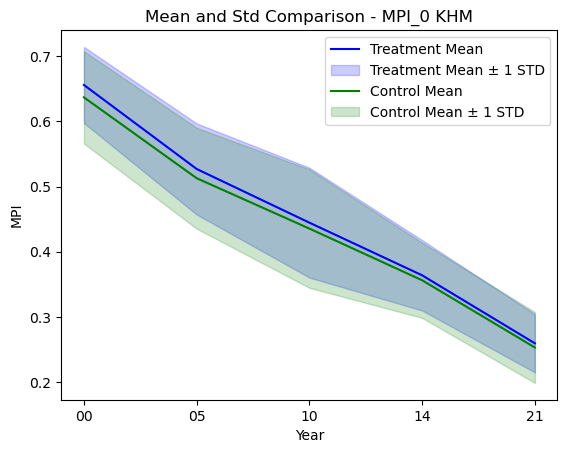

In [57]:
plot_mean_std(df1, df2, label1='Treatment', label2='Control', title='Mean and Std Comparison - MPI_0 KHM')

In [58]:
# Group by 'Treatment' and compute descriptive statistics for 'mpi_0'
grouped_stats = mpi_p['21'].groupby('Treatment')['mpi_0'].describe().transpose()

# Display the results
grouped_stats.to_clipboard()

In [62]:
mpi['21-22'].columns

Index(['DHSID', 'DHSCC', 'DHSYEAR', 'DHSCLUST', 'CCFIPS', 'ADM1FIPS',
       'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME',
       'DHSREGCO', 'DHSREGNA', 'SOURCE', 'URBAN_RURA', 'LATNUM', 'LONGNUM',
       'ALT_GPS', 'ALT_DEM', 'DATUM', 'clust_no', 'area', 'region', 'mpi_0',
       'mpi_0_SE', 'mpi_0_loCI', 'mpi_0_upCI', 'mpi_3', 'mpi_3_SE',
       'mpi_3_loCI', 'mpi_3_upCI', 'tot_ppl', 'pct_pplmis', 'geometry',
       'index_right', 'grid_id', 'cf_buffer5'],
      dtype='object')